In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/widsdatathon2024-challenge1/sample_submission.csv
/kaggle/input/widsdatathon2024-challenge1/training.csv
/kaggle/input/widsdatathon2024-challenge1/test.csv


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression
from scipy.special import expit as sigmoid  # Logistic function
from sklearn.impute import KNNImputer

from sklearn.metrics import f1_score
pd.set_option('display.max_columns', None)

import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
sample_submission = pd.read_csv('/kaggle/input/widsdatathon2024-challenge1/sample_submission.csv')
train_df = pd.read_csv('/kaggle/input/widsdatathon2024-challenge1/training.csv')
test_df = pd.read_csv('/kaggle/input/widsdatathon2024-challenge1/test.csv')

In [4]:
print(train_df.shape)
display(train_df.head())
print(test_df.shape)
display(test_df.head())

(12906, 83)


,patient_id,patient_race,payer_type,patient_state,patient_zip3,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,metastatic_first_novel_treatment,metastatic_first_novel_treatment_type,Region,Division,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,DiagPeriodL90D
0,475714,NaN,MEDICAID,CA,924,84,F,NaN,C50919,Malignant neoplasm of unsp site of unspecified...,C7989,NaN,NaN,West,Pacific,31437.75000,1189.562500,30.642857,16.014286,15.542857,17.614286,14.014286,11.614286,11.557143,7.571429,4.000000,2.100000,49.857143,50.142857,36.571429,11.885714,47.114286,4.442857,3.928571,52.228571,52996.28571,3.142857,4.000000,6.157143,5.142857,6.271429,10.142857,13.300000,20.000000,12.742857,11.571429,7.528571,19.100000,24563.57143,44.585714,8674.500000,2.646343e+05,1165.000000,37.442857,33.257143,29.200000,25.914286,8.357143,3.257143,11.614286,39.557143,61.528571,8.471429,13.428571,0.000000,44.100000,13.100000,5.100000,1.485714,0.342857,27.114286,8.757143,66.685714,12.871429,22.542857,10.100000,27.814286,11.200000,3.500000,52.237210,8.650555,18.606528,1
1,349367,White,COMMERCIAL,CA,928,62,F,28.49,C50411,Malig neoplm of upper-outer quadrant of right ...,C773,NaN,NaN,West,Pacific,39121.87879,2295.939394,38.200000,11.878788,13.354545,14.230303,13.418182,13.333333,14.060606,10.248485,5.951515,3.503030,49.893939,50.106061,50.245455,9.827273,35.290909,4.651515,3.622727,61.736364,102741.63640,2.327273,1.536364,2.648485,2.178788,2.409091,5.163636,7.972727,13.936364,12.469697,19.760606,29.596970,49.357576,41287.27273,61.463636,11725.666670,6.776885e+05,2003.125000,34.753125,14.230303,19.987879,29.796970,23.739394,12.245455,35.984848,47.918182,65.230303,5.103030,15.224242,0.027273,54.030303,2.527273,20.827273,0.587879,0.300000,11.645455,10.081818,37.948485,8.957576,10.109091,8.057576,30.606061,7.018182,4.103030,42.301121,8.487175,20.113179,1
2,138632,White,COMMERCIAL,TX,760,43,F,38.09,C50112,Malignant neoplasm of central portion of left ...,C773,NaN,NaN,South,West South Central,21996.68333,626.236667,37.906667,13.028333,14.463333,12.531667,13.545000,12.860000,12.770000,11.426667,6.565000,2.811667,50.123333,49.876667,55.753333,12.330000,27.195000,4.710000,3.260667,55.801667,85984.74138,2.483333,1.305000,2.716667,2.938333,2.766667,6.763333,12.061667,15.835000,13.560000,20.875000,18.680000,39.555000,40399.03333,72.745000,7786.583333,2.377131e+05,1235.907407,29.358491,10.811667,27.038333,32.368333,19.678333,10.115000,29.793333,37.308475,66.428333,4.560000,13.722034,3.650847,75.820000,9.231667,3.618333,0.463333,0.146667,3.816667,6.898333,19.370000,11.253333,9.663333,3.356667,31.394915,15.066667,7.446667,40.108207,7.642753,14.839351,1
3,617843,White,COMMERCIAL,CA,926,45,F,NaN,C50212,Malig neoplasm of upper-inner quadrant of left...,C773,NaN,NaN,West,Pacific,32795.32558,1896.220930,42.871429,10.071429,12.135714,12.538095,12.464286,12.650000,14.847619,12.280952,8.216667,4.759524,49.066667,50.933333,52.604762,11.623810,31.142857,4.62

(5792, 82)


,patient_id,patient_race,payer_type,patient_state,patient_zip3,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,metastatic_first_novel_treatment,metastatic_first_novel_treatment_type,Region,Division,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02
0,573710,White,MEDICAID,IN,467,54,F,NaN,C50412,Malig neoplasm of upper-outer quadrant of left...,C773,NaN,NaN,Midwest,East North Central,5441.435484,85.620968,40.880328,12.732258,14.088710,10.659677,11.625806,11.208065,15.619355,12.322581,8.409677,3.343548,49.154839,50.845161,55.175806,13.982258,24.266129,6.583871,3.073226,52.980645,66187.22807,1.611290,1.277419,2.645161,3.853226,3.172581,13.275806,12.633871,21.485484,16.717742,15.238710,8.070968,23.309677,33553.43333,84.112903,2064.741935,152749.5370,825.122449,23.895455,12.429032,40.667742,28.959677,11.895161,6.046774,17.941935,35.591379,63.303226,3.406557,10.655357,5.551786,94.793548,0.364516,0.303226,0.119355,0.009677,0.770968,3.630645,3.564516,13.996774,7.985484,0.969355,24.955357,10.838710,8.080645,38.724876,7.947165,11.157161
1,593679,NaN,COMMERCIAL,FL,337,52,F,NaN,C50912,Malignant neoplasm of unspecified site of left...,C787,NaN,NaN,South,South Atlantic,19613.820510,1555.107692,49.107692,8.069231,8.587179,10.684615,11.302564,10.971795,15.823077,15.902564,11.828205,6.815385,49.658974,50.341026,44.800000,17.779487,29.102564,8.310256,2.917105,46.665789,64711.71053,3.873684,2.044737,3.807895,4.239474,4.242105,9.347368,13.018421,17.373684,12.889474,14.442105,14.702632,29.144737,34678.61538,68.673684,8502.230769,265860.6053,1343.394737,34.957895,8.379487,26.558974,30.200000,22.100000,12.764103,34.864103,43.250000,57.035897,5.002632,11.564103,0.005128,78.217949,10.889744,3.453846,0.187179,0.076923,1.841026,5.328205,10.261538,16.020513,13.602564,2.836842,23.952632,10.579487,9.302564,36.918257,7.838973,13.599985
2,184532,Hispanic,MEDICAID,CA,917,61,F,NaN,C50911,Malignant neoplasm of unsp site of right femal...,C773,NaN,NaN,West,Pacific,43030.500000,2048.578261,38.852174,11.306522,12.897826,14.121739,13.532609,13.160870,13.378261,11.473913,6.380435,3.736957,49.052174,50.947826,48.504348,10.117391,36.408696,4.969565,3.674783,59.219565,86330.39130,2.226087,1.528261,2.897826,2.747826,3.173913,6.647826,9.617391,15.965217,13.589130,19.752174,21.847826,41.600000,34317.82609,61.397826,12609.260870,572606.5000,1778.000000,34.595652,17.491304,22.656522,29.263043,20.200000,10.404348,30.604348,46.208696,63.154348,6.197826,15.708696,0.015217,38.708696,3.963043,25.565217,1.193478,0.269565,18.858696,11.426087,47.726087,9.895652,10.515217,12.745652,32.530435,7.263043,3.810870,47.310325,9.595719,20.084231
3,447383,Hispanic,MEDICARE ADVANTAGE,CA,917,64,F,NaN,C50912,Malignant neoplasm of unspecified site of left...,C779,NaN,NaN,West,Pacific,43030.500000,2048.578261,38.852174,11.306522,12.897826,14.121739,13.532609,13.160870,13.378261,11.473913,6.380435,3.736957,49.052174,50.947826,48.504348,10.117391,36.408696,4.969565,3.6

In [5]:
train_df.columns

Index(['patient_id', 'patient_race', 'payer_type', 'patient_state',
       'patient_zip3', 'patient_age', 'patient_gender', 'bmi',
       'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc',
       'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment',
       'metastatic_first_novel_treatment_type', 'Region', 'Division',
       'population', 'density', 'age_median', 'age_under_10', 'age_10_to_19',
       'age_20s', 'age_30s', 'age_40s', 'age_50s', 'age_60s', 'age_70s',
       'age_over_80', 'male', 'female', 'married', 'divorced', 'never_married',
       'widowed', 'family_size', 'family_dual_income',
       'income_household_median', 'income_household_under_5',
       'income_household_5_to_10', 'income_household_10_to_15',
       'income_household_15_to_20', 'income_household_20_to_25',
       'income_household_25_to_35', 'income_household_35_to_50',
       'income_household_50_to_75', 'income_household_75_to_100',
       'income_household_100_to_150', 'in

##### Creating copies of both train and test datasets

In [6]:
train_df1 = train_df.copy()
test_df1 = test_df.copy()

## EDA

In [7]:
train_df.DiagPeriodL90D.value_counts(normalize=True)

DiagPeriodL90D
1    0.624516
0    0.375484
Name: proportion, dtype: float64

In [8]:
train_df.shape
test_df.shape

(5792, 82)

In [9]:
desc = pd.DataFrame(index = list(train_df))
desc['type'] = train_df.dtypes
desc['count'] = train_df.count()
desc['nunique'] = train_df.nunique()
desc['%unique'] = desc['nunique'] /len(train_df) * 100
desc['null'] = train_df.isnull().sum()
desc['%null'] = desc['null'] / len(train_df) * 100
desc = pd.concat([desc,train_df.describe().T.drop('count',axis=1)],axis=1)
desc.sort_values(by=['type','null']).style.background_gradient(axis=0)

,type,count,nunique,%unique,null,%null,mean,std,min,25%,50%,75%,max
patient_id,int64,12906,12906,100.000000,0,0.000000,547381.196033,260404.959974,100063.000000,321517.000000,543522.000000,772671.750000,999896.000000
patient_zip3,int64,12906,739,5.726019,0,0.000000,573.754300,275.447534,101.000000,331.000000,554.000000,846.000000,999.000000
patient_age,int64,12906,67,0.519138,0,0.000000,59.183326,13.335216,18.000000,50.000000,59.000000,67.000000,91.000000
DiagPeriodL90D,int64,12906,2,0.015497,0,0.000000,0.624516,0.484266,0.000000,0.000000,1.000000,1.000000,1.000000
population,float64,12905,738,5.718271,1,0.007748,20744.441237,13886.903756,635.545455,9463.896552,19154.190480,30021.278690,71374.131580
density,float64,12905,738,5.718271,1,0.007748,1581.950419,2966.305306,0.916667,171.857143,700.337500,1666.515385,21172.000000
age_median,float64,12905,728,5.640787,1,0.007748,40.502259,4.036963,20.600000,37.129825,40.639344,42.934783,54.570000
age_under_10,float64,12905,718,5.563304,1,0.007748,11.122784,1.512376,0.000000,10.160000,11.039216,12.190000,17.675000
age_10_to_19,float64,12905,725,5.617542,1,0.007748,12.945265,1.923974,6.314286,11.741176,12.923944,14.019767,35.300000
age_20s,float64,12905,724,5.609794,1,0.007748,13.290376,3.354103,5.925000,11.013415,12.538095,14.971053,62.100000


#### The above descriptive statistics shows that there are numerical columns with a big portion of missing values like patient_race, metastatic_first_novel_treatment, metastastic_first_novel_treatment_type and bmi. These columns have at least 49% missing values but there are also other columns with missing values but percentage is small. Another observation is that there are 11 categorical columns

#### Dropping the columns with many null values

In [10]:
cols_to_delete = ['metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type','patient_race', 'bmi']
train_df.drop(cols_to_delete, axis=1, inplace=True)
test_df.drop(cols_to_delete, axis=1, inplace=True)

In [11]:
display(train_df.shape)
display(test_df.shape)

(12906, 79)

(5792, 78)

<Axes: >

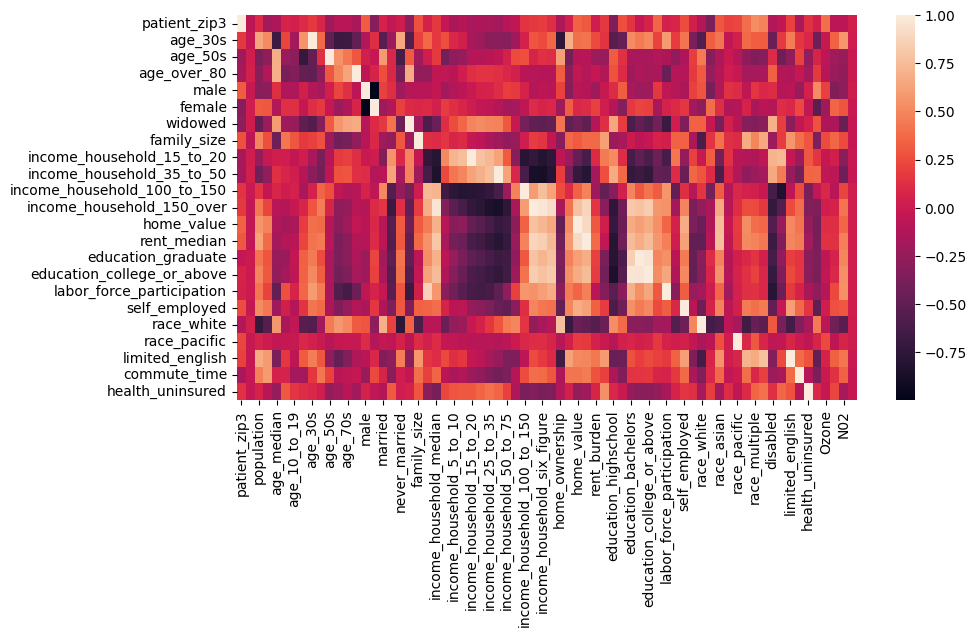

In [12]:
# Let's look at some correlations

corr_df = train_df.drop(['patient_id'],axis=1).select_dtypes(exclude='object').corr()

# only looking at correlations showing a coefficient higher than 0.01
corr_df = corr_df[abs(corr_df)>0.005].dropna(how='any',axis=0)
corr_df = corr_df[abs(corr_df)>0.005].dropna(how='any',axis=1)

plt.figure(figsize=(10,5))
mask = np.triu(np.ones_like(corr_df, dtype=bool))
sns.heatmap(corr_df)

In [13]:
# load statmodels functions
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# compute the vif for all given features
def compute_vif(considered_features):
    
    X = train_df[considered_features].dropna()
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

# features to consider removing
considered_features = list(corr_df.index)

# compute vif 
compute_vif(considered_features).sort_values('VIF', ascending=False)

,Variable,VIF
4,male,1.547599e+07
5,female,1.547584e+07
15,education_college_or_above,2.909348e+01
14,education_graduate,1.971654e+01
11,income_household_150_over,1.809030e+01
13,rent_median,1.616872e+01
12,home_value,8.704920e+00
9,income_household_35_to_50,5.247943e+00
16,labor_force_participation,5.203227e+00
10,income_household_100_to_150,5.059728e+00


1. The **Male & Female** variables have high correlation pointing to possible multicollinearity. 
2. Variables: **'education_college_or_above', 'education_graduate', 'income_household_150_over', and 'rent_median'** also have relatively high VIF values, indicating potential multicollinearity.

In [14]:
considered_features.remove('male')
vif_results = compute_vif(considered_features).sort_values('VIF', ascending=False)
print(vif_results)

                       Variable        VIF
14   education_college_or_above  29.093186
13           education_graduate  19.708725
10    income_household_150_over  18.086411
12                  rent_median  16.166861
11                   home_value   8.703977
8     income_household_35_to_50   5.247698
15    labor_force_participation   5.197822
9   income_household_100_to_150   5.059564
5                       widowed   4.337022
7     income_household_15_to_20   4.284186
17                   race_white   4.227556
1                       age_30s   3.851750
6                   family_size   3.247305
19              limited_english   3.050806
16                self_employed   3.048463
3                   age_over_80   2.924668
20                 commute_time   2.758109
0                  patient_zip3   2.317667
2                       age_50s   2.084668
21             health_uninsured   2.060373
4                        female   1.478239
18                 race_pacific   1.150824


We can also remove **education_college_or_above** and check how the remaining variables are correlated

In [15]:
considered_features.remove('education_college_or_above')
vif_results = compute_vif(considered_features).sort_values('VIF', ascending=False)
print(vif_results)

                       Variable        VIF
10    income_household_150_over  17.371947
12                  rent_median  16.085945
11                   home_value   8.703087
13           education_graduate   6.614062
8     income_household_35_to_50   5.246897
14    labor_force_participation   5.017464
9   income_household_100_to_150   4.910473
5                       widowed   4.311128
7     income_household_15_to_20   4.277998
16                   race_white   4.185754
1                       age_30s   3.753264
18              limited_english   3.043261
6                   family_size   2.996847
15                self_employed   2.935672
3                   age_over_80   2.910610
19                 commute_time   2.643056
0                  patient_zip3   2.309097
2                       age_50s   2.084639
20             health_uninsured   2.057222
4                        female   1.447301
17                 race_pacific   1.150210


The next variable we can consider removing is **income_household_150_over** since it has a high correlation and then we check how the remaining variables are correlated

In [16]:

considered_features.remove('income_household_150_over')
vif_results = compute_vif(considered_features).sort_values('VIF', ascending=False)
print(vif_results)

                       Variable        VIF
11                  rent_median  12.927634
10                   home_value   8.645708
9   income_household_100_to_150   4.808388
13    labor_force_participation   4.615185
12           education_graduate   4.467419
8     income_household_35_to_50   4.390513
5                       widowed   4.295040
7     income_household_15_to_20   4.100934
15                   race_white   4.012066
1                       age_30s   3.538014
17              limited_english   2.953456
3                   age_over_80   2.909370
14                self_employed   2.896343
6                   family_size   2.812912
18                 commute_time   2.564055
0                  patient_zip3   2.270114
19             health_uninsured   2.054286
2                       age_50s   1.963885
4                        female   1.442679
16                 race_pacific   1.149221


The table above shows that 'rent_median' still has high correlation and we can remove it

In [17]:
considered_features.remove('rent_median')
vif_results = compute_vif(considered_features).sort_values('VIF', ascending=False)
print(vif_results)

                       Variable       VIF
10                   home_value  4.840597
9   income_household_100_to_150  4.649689
12    labor_force_participation  4.615156
5                       widowed  4.292779
8     income_household_35_to_50  4.291064
11           education_graduate  3.965142
7     income_household_15_to_20  3.837208
14                   race_white  3.637433
1                       age_30s  3.511780
16              limited_english  2.932165
3                   age_over_80  2.861958
13                self_employed  2.859898
6                   family_size  2.755631
17                 commute_time  2.547187
0                  patient_zip3  2.245117
18             health_uninsured  1.981533
2                       age_50s  1.960411
4                        female  1.438013
15                 race_pacific  1.148463


In [18]:
multicollinearity_cols = ['male', 'rent_median', 'income_household_150_over', 'education_college_or_above' ]

## Summary of categorical variables

In [19]:
# Summarizing categorical columns
from tabulate import tabulate
obj_vars = train_df.select_dtypes(include=['object','category'])
for col in obj_vars.columns:
    data = pd.DataFrame(train_df[col].value_counts())
    data = pd.concat([data,((train_df[col].value_counts()/len(train_df))*100).round(2)],axis=1).head(10)
    headers = ['name','count','percentage']
    print(col)
    print(tabulate(data, headers=headers, tablefmt="pretty"))

payer_type
+--------------------+--------+------------+
|        name        | count  | percentage |
+--------------------+--------+------------+
|     COMMERCIAL     | 6032.0 |   46.74    |
|      MEDICAID      | 2569.0 |   19.91    |
| MEDICARE ADVANTAGE | 2502.0 |   19.39    |
+--------------------+--------+------------+
patient_state
+------+--------+------------+
| name | count  | percentage |
+------+--------+------------+
|  CA  | 2438.0 |   18.89    |
|  TX  | 1155.0 |    8.95    |
|  NY  | 1041.0 |    8.07    |
|  MI  | 858.0  |    6.65    |
|  IL  | 782.0  |    6.06    |
|  OH  | 754.0  |    5.84    |
|  FL  | 609.0  |    4.72    |
|  GA  | 551.0  |    4.27    |
|  PA  | 483.0  |    3.74    |
|  MN  | 377.0  |    2.92    |
+------+--------+------------+
patient_gender
+------+---------+------------+
| name |  count  | percentage |
+------+---------+------------+
|  F   | 12906.0 |   100.0    |
+------+---------+------------+
breast_cancer_diagnosis_code
+--------+--------+---

In [20]:
# Summarizing categorical columns - to check percentage of diagnostics within 90 days, or probability of diagnostic being done in 90 days

obj_vars = train_df.select_dtypes(include=['object','category'])
for col in obj_vars.columns:
    data = pd.DataFrame(train_df[[col,'DiagPeriodL90D']].groupby(col).agg(['sum','count'])).head(10)
    data.columns = ['sum','count']
    data['DiagPeriodL90D_prob'] = np.round(100*data['sum']/data['count'],2)
    data = data.sort_values(by=['DiagPeriodL90D_prob','count'],ascending=False)
    headers = ['sum','count','DiagPeriodL90D_prob']
    print(col)
    print(tabulate(data, headers=headers, tablefmt="pretty"))

payer_type
+--------------------+--------+--------+---------------------+
|                    |  sum   | count  | DiagPeriodL90D_prob |
+--------------------+--------+--------+---------------------+
| MEDICARE ADVANTAGE | 1607.0 | 2502.0 |        64.23        |
|      MEDICAID      | 1568.0 | 2569.0 |        61.04        |
|     COMMERCIAL     | 3612.0 | 6032.0 |        59.88        |
+--------------------+--------+--------+---------------------+
patient_state
+----+--------+--------+---------------------+
|    |  sum   | count  | DiagPeriodL90D_prob |
+----+--------+--------+---------------------+
| CO | 303.0  | 371.0  |        81.67        |
| DC |  14.0  |  20.0  |        70.0         |
| AR |  44.0  |  63.0  |        69.84        |
| DE |  23.0  |  33.0  |        69.7         |
| CA | 1576.0 | 2438.0 |        64.64        |
| FL | 386.0  | 609.0  |        63.38        |
| AZ | 142.0  | 229.0  |        62.01        |
| AL |  26.0  |  50.0  |        52.0         |
| AK |  3.0   |  

In [21]:
train_df.drop(multicollinearity_cols, axis=1, inplace=True)
test_df.drop(multicollinearity_cols, axis=1, inplace=True)

In [22]:
#Dropping columns with high nul values
for column in train_df.columns:
    null_count = train_df[column].isnull().sum()
    percent_nulls = (null_count / train_df.shape[0]) * 100
    if percent_nulls > 1:
        train_df.drop(columns = column,axis = 1,inplace=True)
        test_df.drop(columns = column,axis = 1,inplace=True)

In [23]:
display(train_df.shape)
display(test_df.shape)

(12906, 74)

(5792, 73)

In [24]:
categorical_cols = train_df.select_dtypes(include=['object', 'category']).columns
numerical_cols = train_df.select_dtypes(include=['float64', 'int64']).columns

# Impute categorical columns using mode
for col in categorical_cols:
    if col != 'DiagPeriodL90D':
        mode = train_df[col].mode()[0]
        train_df[col].fillna(mode, inplace=True)
        test_df[col].fillna(mode, inplace=True)

# Impute numerical columns using mean
for col in numerical_cols:
    if col != 'DiagPeriodL90D':
        mean = train_df[col].mean()
        train_df[col].fillna(mean, inplace=True)
        test_df[col].fillna(mean, inplace=True)

In [25]:
display(train_df.shape)
display(test_df.shape)
train_df.columns

(12906, 74)

(5792, 73)

Index(['patient_id', 'patient_state', 'patient_zip3', 'patient_age',
       'patient_gender', 'breast_cancer_diagnosis_code',
       'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code',
       'Region', 'Division', 'population', 'density', 'age_median',
       'age_under_10', 'age_10_to_19', 'age_20s', 'age_30s', 'age_40s',
       'age_50s', 'age_60s', 'age_70s', 'age_over_80', 'female', 'married',
       'divorced', 'never_married', 'widowed', 'family_size',
       'family_dual_income', 'income_household_median',
       'income_household_under_5', 'income_household_5_to_10',
       'income_household_10_to_15', 'income_household_15_to_20',
       'income_household_20_to_25', 'income_household_25_to_35',
       'income_household_35_to_50', 'income_household_50_to_75',
       'income_household_75_to_100', 'income_household_100_to_150',
       'income_household_six_figure', 'income_individual_median',
       'home_ownership', 'housing_units', 'home_value', 'rent_burden',
  

In [26]:
cols_drop = ['age_under_10', 'age_10_to_19', 'age_20s', 'age_30s', 'age_40s',
       'age_50s', 'age_60s', 'age_70s', 'age_over_80',
       'family_dual_income', 'income_household_median',
       'income_household_under_5', 'income_household_5_to_10',
       'income_household_10_to_15', 'income_household_15_to_20',
       'income_household_20_to_25', 'income_household_25_to_35',
       'income_household_35_to_50', 'income_household_50_to_75',
       'income_household_75_to_100', 'income_household_100_to_150',
       'income_household_six_figure', 'income_individual_median',
       'education_less_highschool', 'education_highschool',
       'education_some_college', 'education_bachelors', 'education_graduate',
       'education_stem_degree', 'labor_force_participation',
       'unemployment_rate', 'self_employed', 'farmer', 'race_white',
       'race_black', 'race_asian', 'race_native', 'race_pacific', 'race_other',
       'race_multiple', 'hispanic', ]

In [27]:
train_df.drop(cols_drop, axis=1, inplace=True)
test_df.drop(cols_drop, axis=1, inplace=True)

In [28]:
train_df.isna().sum()

patient_id                          0
patient_state                       0
patient_zip3                        0
patient_age                         0
patient_gender                      0
breast_cancer_diagnosis_code        0
breast_cancer_diagnosis_desc        0
metastatic_cancer_diagnosis_code    0
Region                              0
Division                            0
population                          0
density                             0
age_median                          0
female                              0
married                             0
divorced                            0
never_married                       0
widowed                             0
family_size                         0
home_ownership                      0
housing_units                       0
home_value                          0
rent_burden                         0
disabled                            0
poverty                             0
limited_english                     0
commute_time

In [29]:
obj_df = train_df.select_dtypes(include=['object']).copy()
obj_df.head()

,patient_state,patient_gender,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,Region,Division
0,CA,F,C50919,Malignant neoplasm of unsp site of unspecified...,C7989,West,Pacific
1,CA,F,C50411,Malig neoplm of upper-outer quadrant of right ...,C773,West,Pacific
2,TX,F,C50112,Malignant neoplasm of central portion of left ...,C773,South,West South Central
3,CA,F,C50212,Malig neoplasm of upper-inner quadrant of left...,C773,West,Pacific
4,ID,F,1749,"Malignant neoplasm of breast (female), unspeci...",C773,West,Mountain


In [30]:
obj_df.columns

Index(['patient_state', 'patient_gender', 'breast_cancer_diagnosis_code',
       'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code',
       'Region', 'Division'],
      dtype='object')

In [31]:
from sklearn.preprocessing import LabelEncoder

columns_to_encode = ['patient_state', 'patient_gender', 'breast_cancer_diagnosis_code',
       'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code',
       'Region', 'Division']

train_df[columns_to_encode] = train_df[columns_to_encode].apply(LabelEncoder().fit_transform)
test_df[columns_to_encode] = test_df[columns_to_encode].apply(LabelEncoder().fit_transform)


In [32]:
display(test_df.head())
display(train_df.head())

,patient_id,patient_state,patient_zip3,patient_age,patient_gender,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,Region,Division,population,density,age_median,female,married,divorced,never_married,widowed,family_size,home_ownership,housing_units,home_value,rent_burden,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02
0,573710,14,467,54,0,25,6,3,0,0,5441.435484,85.620968,40.880328,50.845161,55.175806,13.982258,24.266129,6.583871,3.073226,84.112903,2064.741935,152749.5370,23.895455,13.996774,7.985484,0.969355,24.955357,10.838710,8.080645,38.724876,7.947165,11.157161
1,593679,8,337,52,0,41,38,16,2,6,19613.820510,1555.107692,49.107692,50.341026,44.800000,17.779487,29.102564,8.310256,2.917105,68.673684,8502.230769,265860.6053,34.957895,16.020513,13.602564,2.836842,23.952632,10.579487,9.302564,36.918257,7.838973,13.599985
2,184532,4,917,61,0,40,35,3,3,5,43030.500000,2048.578261,38.852174,50.947826,48.504348,10.117391,36.408696,4.969565,3.674783,61.397826,12609.260870,572606.5000,34.595652,9.895652,10.515217,12.745652,32.530435,7.263043,3.810870,47.310325,9.595719,20.084231
3,447383,4,917,64,0,41,38,7,3,5,43030.500000,2048.578261,38.852174,50.947826,48.504348,10.117391,36.408696,4.969565,3.674783,61.397826,12609.260870,572606.5000,34.595652,9.895652,10.515217,12.745652,32.530435,7.263043,3.810870,47.310325,9.595719,20.084231
4,687972,4,900,40,0,25,6,7,3,5,36054.117650,5294.330882,36.653846,49.489231,33.478462,11.301538,50.456923,4.766154,3.442857,31.504687,12949.117650,873755.9661,37.367742,11.901538,20.760000,14.737500,30.709375,10.341538,3.030769,41.186992,11.166898,21.644261


,patient_id,patient_state,patient_zip3,patient_age,patient_gender,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,Region,Division,population,density,age_median,female,married,divorced,never_married,widowed,family_size,home_ownership,housing_units,home_value,rent_burden,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,DiagPeriodL90D
0,475714,4,924,84,0,48,42,41,3,5,31437.75000,1189.562500,30.642857,50.142857,36.571429,11.885714,47.114286,4.442857,3.928571,44.585714,8674.500000,2.646343e+05,37.442857,12.871429,22.542857,10.100000,27.814286,11.200000,3.500000,52.237210,8.650555,18.606528,1
1,349367,4,928,62,0,29,12,3,3,5,39121.87879,2295.939394,38.200000,50.106061,50.245455,9.827273,35.290909,4.651515,3.622727,61.463636,11725.666670,6.776885e+05,34.753125,8.957576,10.109091,8.057576,30.606061,7.018182,4.103030,42.301121,8.487175,20.113179,1
2,138632,43,760,43,0,18,23,3,2,8,21996.68333,626.236667,37.906667,49.876667,55.753333,12.330000,27.195000,4.710000,3.260667,72.745000,7786.583333,2.377131e+05,29.358491,11.253333,9.663333,3.356667,31.394915,15.066667,7.446667,40.108207,7.642753,14.839351,1
3,617843,4,926,45,0,22,4,3,3,5,32795.32558,1896.220930,42.871429,50.933333,52.604762,11.623810,31.142857,4.623810,3.098095,59.221429,12171.302330,1.012474e+06,32.030952,8.845238,8.688095,5.280952,27.561905,4.404762,4.809524,42.070075,7.229393,15.894123,0
4,817482,13,836,55,0,7,18,3,3,3,10886.26000,116.886000,43.473469,47.688000,57.882000,14.964000,21.760000,5.406000,3.352653,77.098000,3768.060000,2.498457e+05,27.029730,15.276000,11.224000,1.946000,26.170213,12.088000,13.106000,41.356058,4.110749,11.722197,0


In [33]:
X = train_df.drop(columns=['DiagPeriodL90D'])
y = train_df['DiagPeriodL90D']

In [34]:
X_train, X_val, y_train,y_val= train_test_split(X, y, test_size=0.2, random_state=42)

#### Pooling

In [35]:
train_pool = Pool(X_train,y_train)
val_pool= Pool(X_val,y_val)
test_pool = Pool(test_df)

#### Training the model

#### Model1

In [36]:
#cat_1 = CatBoostClassifier(verbose=200,learning_rate = 0.02, depth=3)
#cat_1.fit(train_pool, eval_set=val_pool)
#y_pred_catboost_1 = cat_1.predict(val_pool)

#f1_score_catboost_1 = f1_score(y_val, y_pred_catboost_1)
#print(f'F1 Score (CatBoost): {f1_score_catboost_1}')

#### Model2

In [37]:
cat_2 = CatBoostClassifier(iterations=195, verbose=200, learning_rate = 0.06, depth=4)
cat_2.fit(train_pool, eval_set=val_pool)
y_pred_catboost_2 = cat_2.predict(val_pool)

f1_score_catboost_2 = f1_score(y_val, y_pred_catboost_2)
print(f'F1 Score (CatBoost): {f1_score_catboost_2}')

0:	learn: 0.6646663	test: 0.6642026	best: 0.6642026 (0)	total: 59.4ms	remaining: 11.5s
194:	learn: 0.4432007	test: 0.4617266	best: 0.4617266 (194)	total: 1.13s	remaining: 0us

bestTest = 0.461726619
bestIteration = 194

F1 Score (CatBoost): 0.8683770217512548


#### Prediction

In [38]:
#y_pred_1 = cat_1.predict_proba(test_pool)[:, 1]
y_pred_2 = cat_2.predict_proba(test_pool)[:, 1]
y_pred_2


array([0.82475743, 0.74240689, 0.81459614, ..., 0.86368846, 0.096495  ,
       0.80977645])

In [39]:
#Submission csv
submit_df = pd.DataFrame(y_pred_2,index=test_df['patient_id'],columns=['DiagPeriodL90D'])
submit_df.to_csv('submissionk11.csv')